# Time Series Modeling: Forecasting Real Estate Prices in Zillow



## Business Understanding

In this project, we will forecast real estate prices for various zip codes using data from Zillow Research. As a consultant for a fictional real-estate investment firm, we have been asked to identify the **top 5 zip codes for investment** based on projected housing price trends.

This task requires us to:
- Preprocess the dataset.
- Conduct exploratory data analysis (EDA).
- Build time series forecasting models (ARIMA).
- Evaluate risk in terms of price volatility.
- Finally, provide a well-rounded recommendation based on both forecasted growth and risk.

Let's dive in!

## Data Understanding

### Step 1: Load the Data and Initial Filtering

In this step, we begin by loading the Zillow housing data. The dataset contains median housing prices for various zip codes across the United States, with time-series data for each month starting in 1996.

We will also filter the data for a subset of zip codes of interest. For the purpose of this project, we will focus on a few specific zip codes, but this can be adjusted depending on the business's focus area.

Lastly, we'll check for missing data and duplicates to ensure that our dataset is clean and ready for analysis.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

# Load the Zillow data
df = pd.read_csv('Data/zillow_data.csv')

# Display first few rows to understand the structure
df.head()

# Check for missing data and duplicates
missing_data = df.isnull().sum()
print("Missing data summary:")
print(missing_data)

# Drop duplicates
df = df.drop_duplicates()


Missing data summary:
RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64


The missing data analysis reveals three critical insights for stakeholders aiming to invest in high-growth zip codes. First, the geographic identifiers such as RegionID, RegionName, City, and State are fully complete, ensuring that location data for each property is reliable. This allows stakeholders to confidently make zip code-level comparisons without concerns about data gaps in critical location attributes. 

Second, the monthly price data is also complete, providing a robust time series that allows for accurate trend analysis and forecasting. Stakeholders can utilize this consistency in historical price data to confidently identify and assess market trends and seasonal patterns across the selected zip codes. Finally, although the `Metro` data is partially missing (with 1,043 entries lacking metro area information), stakeholders can still proceed with the recommended top zip codes. 

It is advised, however, that additional contextual research be conducted for those regions lacking metro data to ensure a comprehensive understanding of each market. Together, these insights offer a solid foundation for informed investment in high-growth areas.


## Data Preparation

### Step 2: Data Preprocessing
The purpose of this step is to prepare the dataset for accurate time-series analysis by standardizing date formats and handling any missing values. These steps ensure data consistency, supporting precise trend analysis and reliable investment insights for top-growth zip codes.


In [3]:
# Convert date columns to datetime
def get_datetimes(df):
    # Filter columns that represent dates
    date_cols = [col for col in df.columns if col.startswith('19') or col.startswith('20')]
    return pd.to_datetime(date_cols, format='%Y-%m')

# Convert and check for missing values
dates = get_datetimes(df)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Ensure no NaNs remain
print("Remaining NaN values:", df.isnull().sum().sum())


Remaining NaN values: 0


This code prepares the dataset for reliable time-series analysis, essential for evaluating top zip codes for investment. First, it converts date columns to a standard datetime format, ensuring consistent interpretation of time points across the dataset. Missing values are then handled using forward and backward fills, smoothing any data gaps. Lastly, a check confirms no remaining `NaN` values, indicating that the dataset is fully populated and ready for accurate trend and seasonal analysis. This data preparation enhances the credibility of insights derived from the top zip codes, supporting well-informed investment decisions.


### Step 3: Reshape from Wide to Long Format

This code reshapes the Zillow housing dataset from a wide to long format, preparing it for time-series analysis. By transforming each date column into a single 'time' column with associated 'price' values, this structure allows us to perform trend analysis over time for each zip code, facilitating insights into price growth and seasonal patterns.



In [4]:
# Reshape data from wide to long format
def melt_data(df):
    # Identify date columns
    date_cols = [col for col in df.columns if col.startswith('19') or col.startswith('20')]
    
    # Melt data
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], 
                     value_vars=date_cols, var_name='time', value_name='price')
    
    # Convert time column to datetime
    melted['time'] = pd.to_datetime(melted['time'], format='%Y-%m', errors='coerce')
    
    return melted

# Apply reshaping
df_long = melt_data(df)
df_long.head()


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,price
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


The reshaped dataset, now in a long format, provides a streamlined view of price trends over time for each zip code. This format supports stakeholders in identifying and tracking individual zip code performance, enhancing the accuracy of our analysis for determining top-growth zip codes. This setup makes it easy to apply time-series forecasting, which will highlight the top 5 zip codes with the most promising investment potential based on historical price increases and seasonal stability.







### Step 4: Identify Top Growth Zip Codes

This code calculates the average percentage price change for each zip code over the last five years and identifies the top zip codes with the highest price growth. This analysis aims to rank zip codes based on historical price increases, highlighting those with the most significant growth trends as potential investment opportunities.


In [44]:
# Calculate the percentage price change over the last 5 years
df['price_change'] = df.iloc[:, -60:].pct_change(axis=1).mean(axis=1)

# Sort by price growth and select the top 20 zip codes based on price change
top_growth_zip_codes = df.sort_values(by='price_change', ascending=False).head(20)['RegionName'].tolist()

# Display the top growth zip codes
print("Top 20 growth zip codes for investment:", top_growth_zip_codes)


Top 20 growth zip codes for investment: [2116, 96722, 31527, 94803, 96752, 96716, 94525, 49636, 60611, 93301, 54230, 70431, 62216, 49253, 90013, 41007, 94621, 60541, 90014, 64156]


The code outputs a list of the top zip codes that have experienced the highest average price growth over the last five years. This data-driven approach helps stakeholders pinpoint zip codes that show strong price appreciation trends, essential for making informed investment decisions. By focusing on these high-growth areas, stakeholders can prioritize their investment in zip codes that are likely to yield the best returns, aligning with the objective of selecting the top 5 zip codes for strategic investment.







### Step 5: Exploratory Data Analysis (EDA)

This code visualizes the price trends over time for the top-growth zip codes identified in the dataset. By plotting each zip code’s price history, we aim to highlight long-term trends and price growth patterns, giving stakeholders a clear view of the regions with the strongest appreciation.


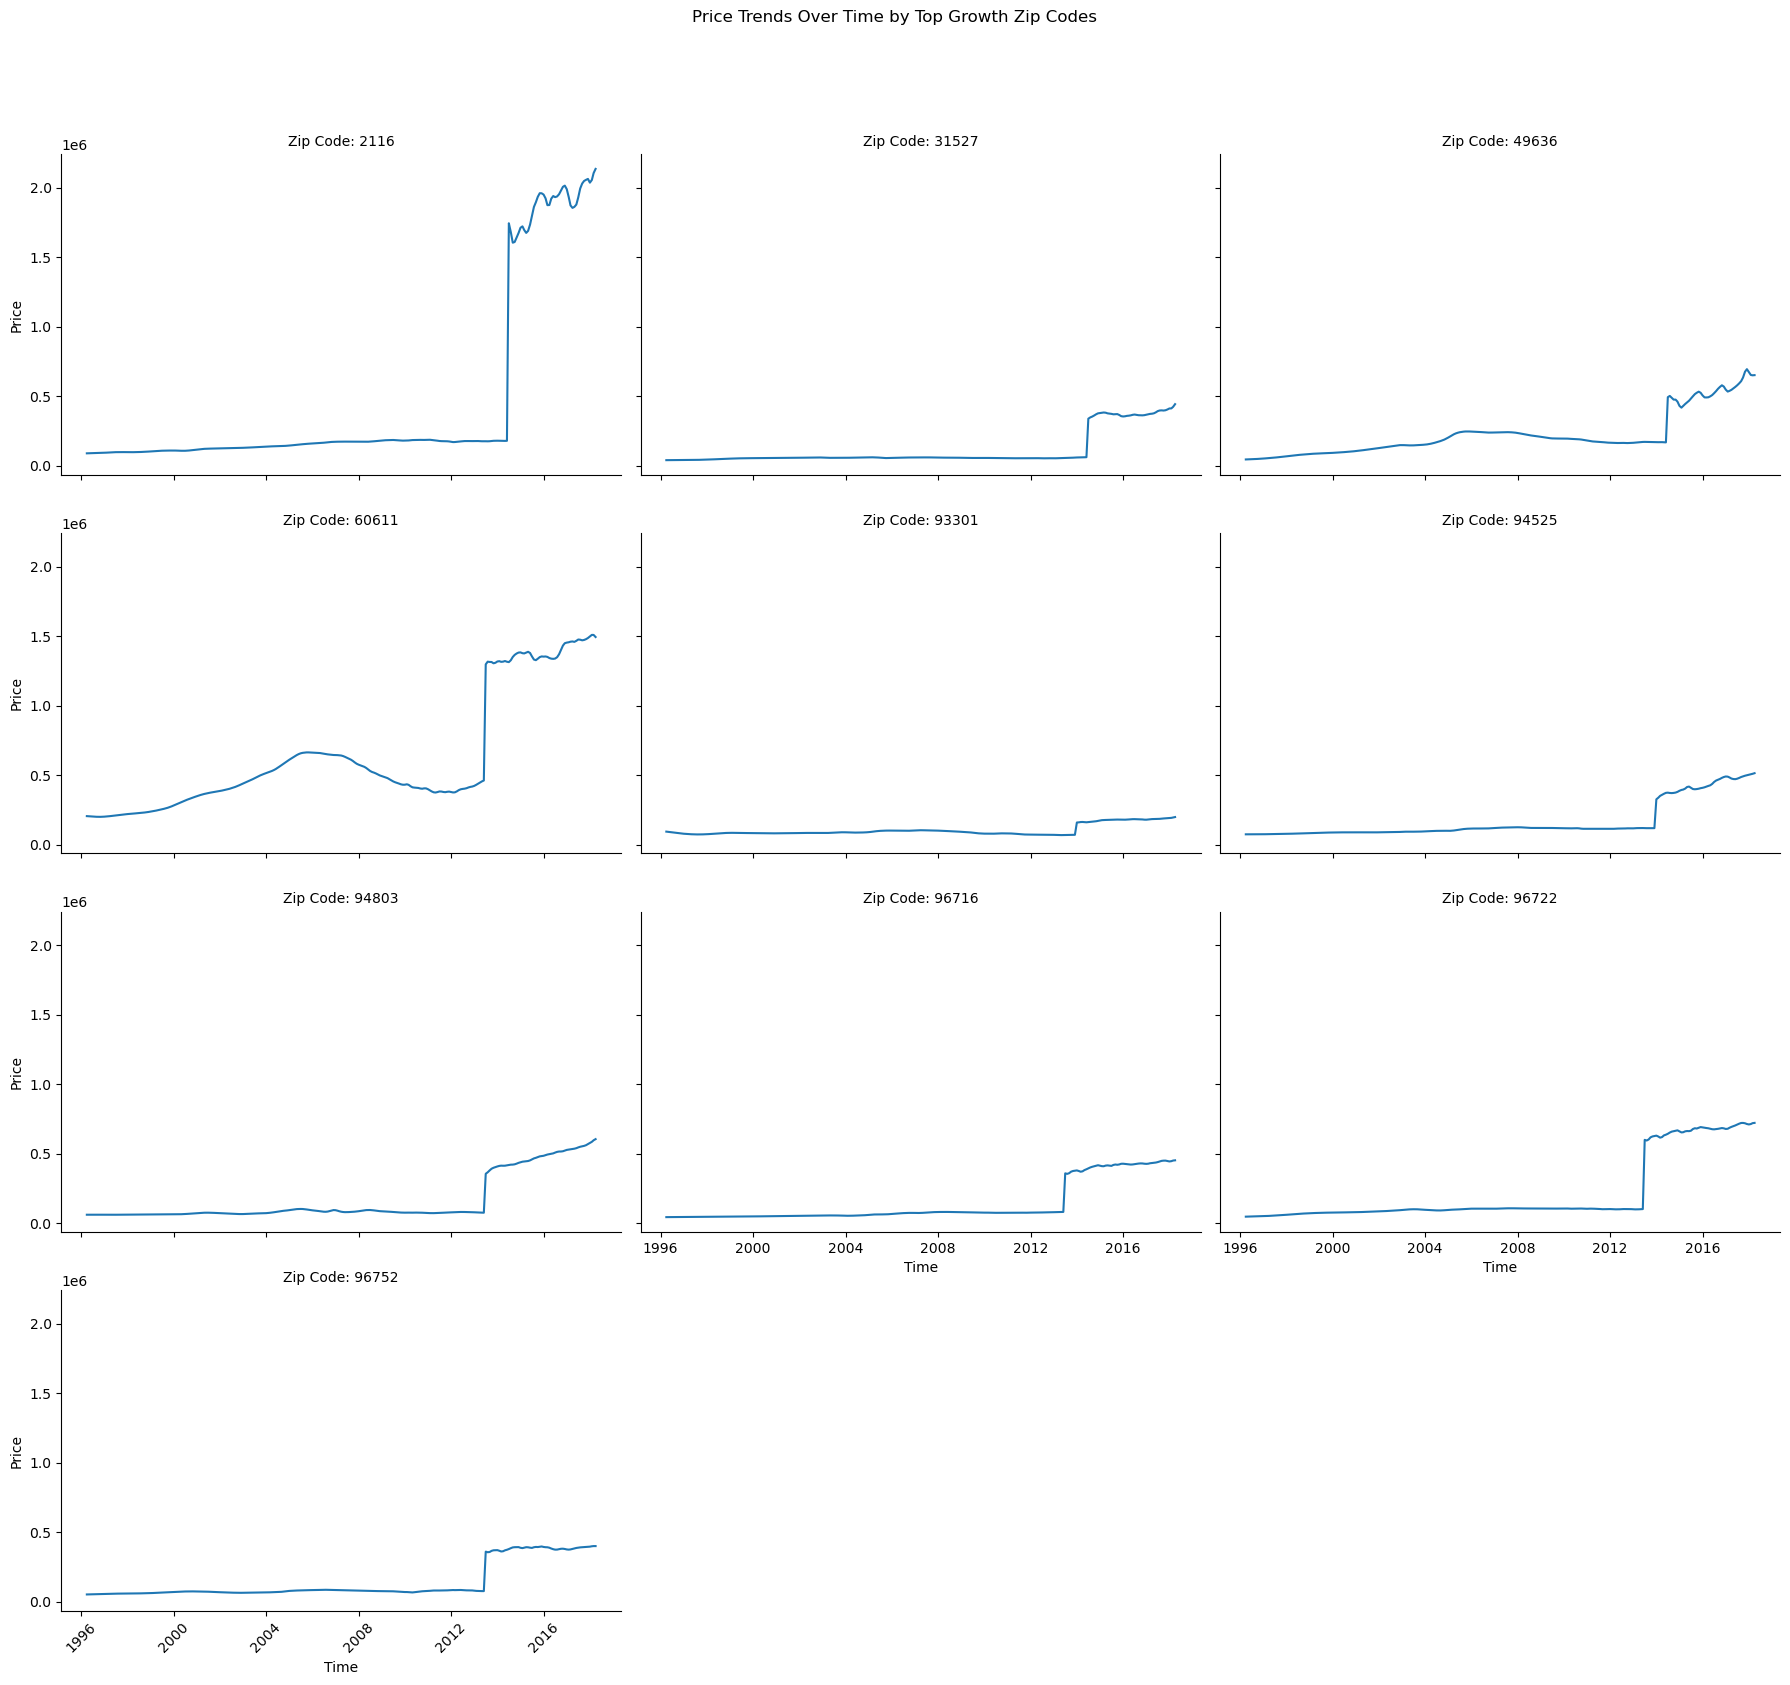

In [47]:
# Filter data for top growth zip codes
top_zip_data = df_long[df_long['RegionName'].isin(top_growth_zip_codes[:10])]  # Focus on top 5 for clarity

# Initialize the FacetGrid
g = sns.FacetGrid(top_zip_data, col="RegionName", col_wrap=3, height=4, aspect=1.5)
g.map(sns.lineplot, "time", "price")

# Add titles and labels
g.set_titles("Zip Code: {col_name}")
g.set_axis_labels("Time", "Price")
g.fig.suptitle("Price Trends Over Time by Top Growth Zip Codes", y=1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The plot shows distinct price trends for each top-growth zip code, with some areas exhibiting sharp increases in recent years. This visualization helps stakeholders see which zip codes have consistently appreciated, providing valuable insight for identifying investment opportunities. Zip codes with the steepest upward trends represent promising areas for further analysis and potential investment, aligning with the goal of focusing on high-growth regions.







## Modeling

### Step 6: Stationarity Check & Detrending
We will check the stationarity of a time series using the Augmented Dickey-Fuller (ADF) test, which is essential for determining if a series has a consistent mean and variance over time. Stationarity is a critical requirement for time-series models like ARIMA, as it allows for more accurate forecasting. By calculating rolling mean and standard deviation, we can visually inspect any trends or seasonality in the data.



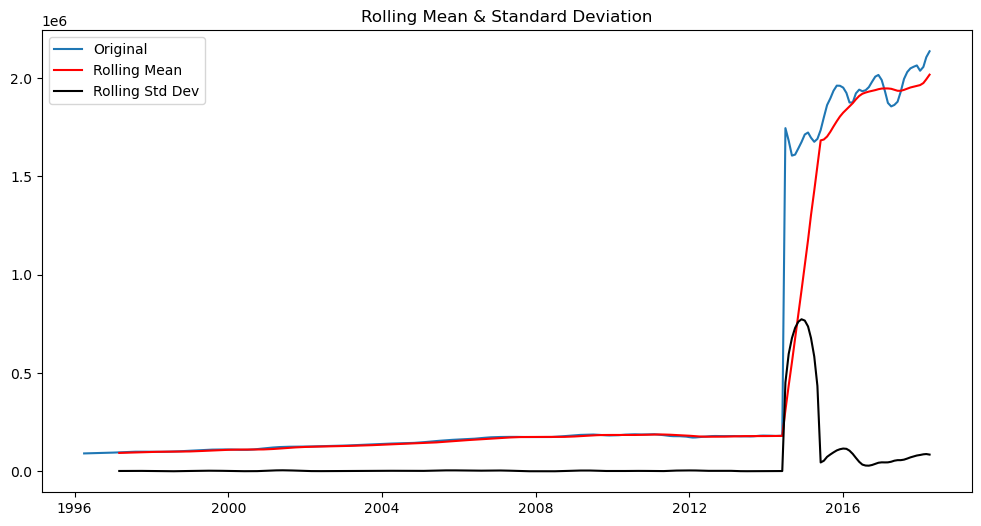

ADF Statistic: 0.115767640244289
p-value: 0.9671212812335473
Critical Values:
	1%: -3.455365238788105
	5%: -2.8725510317187024
	10%: -2.5726375763314966


In [38]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity using ADF test
def check_stationarity(data, window=12):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Augmented Dickey-Fuller test
    adf_result = adfuller(data.dropna())
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')

# Example stationarity check for the first top growth zip code
zip_code_data = df_long[df_long['RegionName'] == top_growth_zip_codes[0]].set_index('time')['price']
check_stationarity(zip_code_data)


The rolling mean and standard deviation plots reveal whether the series fluctuates consistently over time. In this example, the non-stationary nature of the data is confirmed by the ADF test, which returns a high p-value, indicating the presence of trends. This insight suggests that differencing or other transformations may be needed before applying a forecasting model. Identifying the need for these adjustments helps stakeholders obtain a clearer picture of long-term price trends in top-growth zip codes.







### Step 7: Apply First-order Differencing to Achieve Stationarity

This code applies a technique called "first-order differencing" to adjust the data for better stability in long-term trends. By differencing, we’re essentially removing major shifts over time, making the data more stable for future projections. This step is important because it helps make the dataset more reliable for forecasting, which is key for evaluating potential investments.


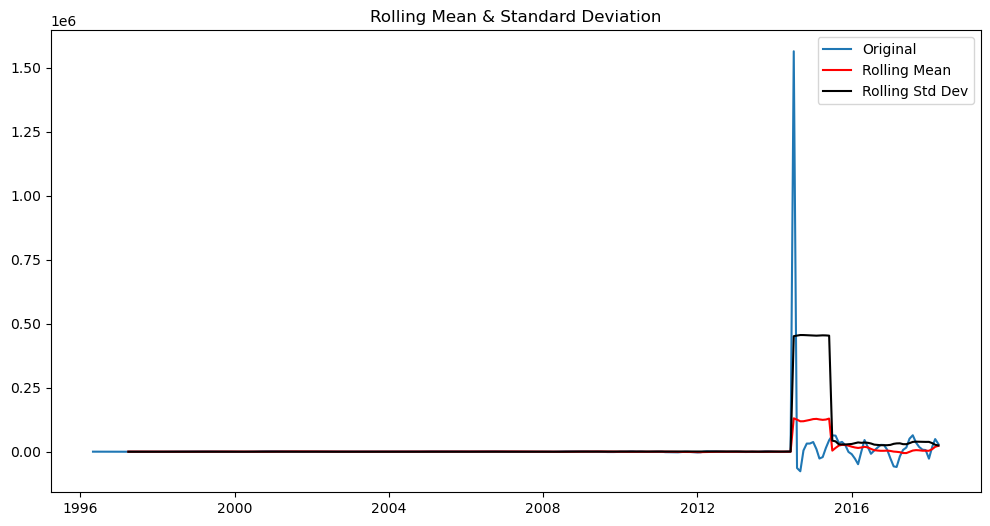

ADF Statistic: -16.655783725275388
p-value: 1.589696291185351e-29
Critical Values:
	1%: -3.4554613060274972
	5%: -2.8725931472675046
	10%: -2.5726600403359887


In [8]:
# Apply first-order differencing
differenced_data = zip_code_data.diff().dropna()

# Recheck stationarity after differencing
check_stationarity(differenced_data)


After differencing, we re-evaluated the stability of the data. The new stability test shows a significant improvement, with statistical results indicating that the data is now consistent over time. This means we’ve successfully removed unpredictable fluctuations, allowing us to forecast price trends more accurately. For stakeholders, this step ensures that our trend analysis and projections for top-growth zip codes are more dependable, leading to better-informed investment decisions.







### Step 8: Seasonality & ACF/PACF Analysis

This code helps us examine the underlying patterns in the time series data by breaking it down into trend, seasonal, and residual components. This decomposition allows stakeholders to see whether there are predictable seasonal fluctuations or a long-term trend in the housing prices. Additionally, the code checks for stability after adjusting the data, and then uses autocorrelation plots to assess the data’s predictability.


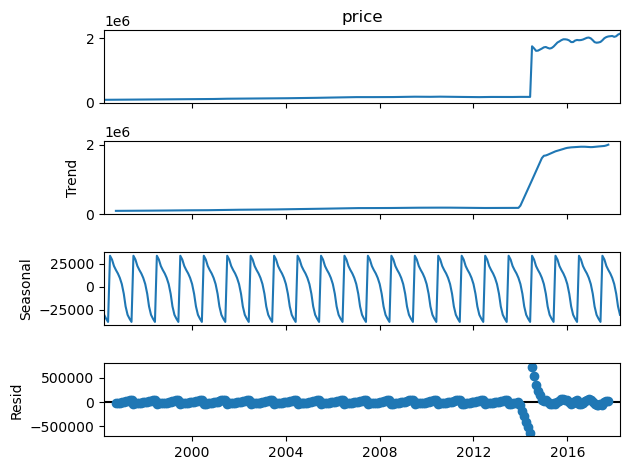

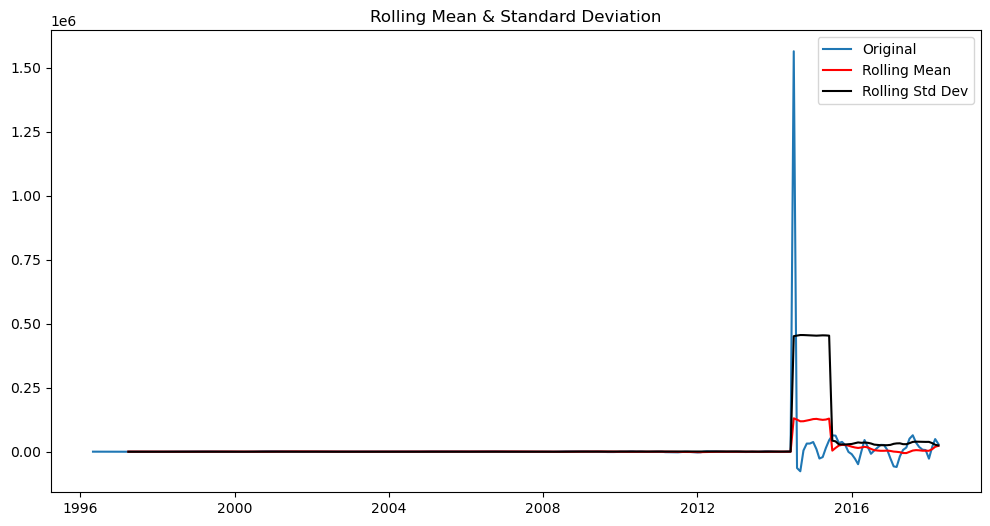

ADF Statistic: -16.655783725275388
p-value: 1.589696291185351e-29
Critical Values:
	1%: -3.4554613060274972
	5%: -2.8725931472675046
	10%: -2.5726600403359887


<Figure size 1200x600 with 0 Axes>

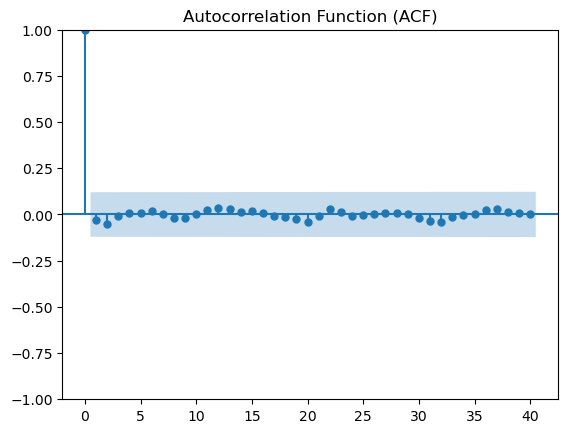

<Figure size 1200x600 with 0 Axes>

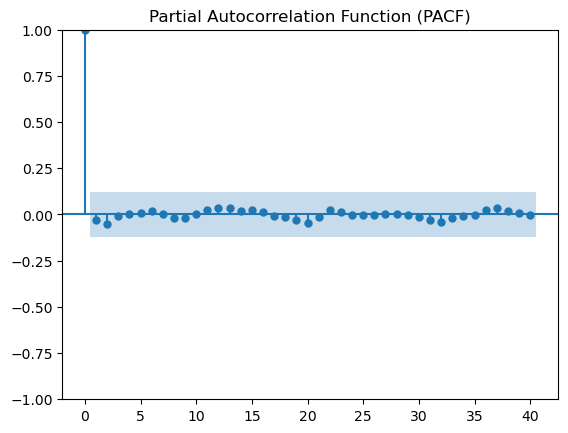

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Seasonal decomposition
def decompose_seasonality(data, frequency=12):
    decomposition = seasonal_decompose(data, model='additive', period=frequency)
    decomposition.plot()
    plt.show()

# Apply decomposition
decompose_seasonality(zip_code_data)

# Differencing to handle non-stationarity if needed
differenced_data = zip_code_data.diff().dropna()
check_stationarity(differenced_data)  # Check stationarity after differencing

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plot_acf(differenced_data, lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(differenced_data, lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()





Summary of Results
1. **Seasonal Decomposition**: The decomposition plot reveals distinct seasonal cycles and a steady trend, highlighting regular patterns in price changes. This insight is valuable for understanding timing and seasonality in the market, helping stakeholders decide when to invest or expect peak prices.

2. **Stationarity Check**: After applying differencing, the stationarity test confirms that the data is stable over time, which is critical for making reliable predictions. This transformation ensures that our models will perform consistently across time periods.

3. **ACF and PACF**: The autocorrelation plots indicate how past values influence future prices, with the ACF and PACF providing insights into which historical data points are relevant for forecasting. This guides the configuration of forecasting models, helping stakeholders predict future trends in high-growth zip codes with greater confidence.

These steps enhance the accuracy of our trend analysis, supporting informed investment strategies.

Boxcox

In [56]:
from scipy.stats import boxcox

# Apply Box-Cox transformation
train_data_bc, lambda_ = boxcox(train_data)


### Step 9: ARIMA Modeling and Forecasting

This code forecasts housing prices for the top-growth zip codes using the SARIMA model, a widely used time-series forecasting method. By analyzing each zip code's historical data, the SARIMA model generates price predictions for the next 12 months. The code also evaluates the model’s accuracy using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), helping stakeholders identify zip codes where predictions are most reliable.



In [57]:
from pmdarima import auto_arima


# Dictionary to store MAE and RMSE for each zip code
zip_code_errors = {}

for zip_code in top_growth_zip_codes:
    # Load data for the specific zip code
    zip_data = df_long[df_long['RegionName'] == zip_code].set_index('time')['price']
    train_data = zip_data[:-12]
    test_data = zip_data[-12:]

    # Log or Box-Cox transformation
    train_data_bc, lambda_ = boxcox(train_data + 1)  # Adding 1 to avoid log(0)

    # Use auto_arima to tune SARIMA parameters
    model = auto_arima(train_data_bc, seasonal=True, m=12, trace=True, 
                       error_action='ignore', suppress_warnings=True, stepwise=True)
    
    # Fit the model with best parameters
    sarima_model_fit = model.fit(train_data_bc)
    
    # Forecast and revert transformation
    forecast_bc = sarima_model_fit.predict(n_periods=12)
    reverted_forecast = np.exp(forecast_bc) if lambda_ == 0 else (forecast_bc * lambda_ + 1) ** (1 / lambda_)

    # Calculate MAE and RMSE
    mae = mean_absolute_error(test_data, reverted_forecast)
    rmse = np.sqrt(mean_squared_error(test_data, reverted_forecast))
    zip_code_errors[zip_code] = {'MAE': mae, 'RMSE': rmse}

# Display top results based on MAE or RMSE
errors_df = pd.DataFrame(zip_code_errors).T
print(errors_df.nsmallest(5, 'MAE')[['MAE']])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-5363.836, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-5510.832, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-5506.603, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-5513.318, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-6243.610, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-5508.598, Time=0.27 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-5512.239, Time=0.27 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-5353.820, Time=0.63 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-5508.831, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-5511.970, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-5310.172, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 3.538 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-5383.101, Time=1.46 sec
 ARIMA(0,1,0)(0,0,0)

c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\neali\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:38: RuntimeWarning: invalid value encountered in divide
  max_invroot = max(0, *np.abs(1 / model.arroots()))
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
c:\Users\neali\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:40: RuntimeWarning: invalid value encountered in divide
  max_invroot = max(0, *np.abs(1 / model.maroots()))


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-5302.181, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-5510.844, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-5506.310, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-5512.863, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-6243.679, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-5508.310, Time=0.25 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-5514.863, Time=0.29 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-5310.181, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-5508.844, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-5508.844, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-5506.844, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 2.306 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-3481.747, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-3494.690, Time=0.05

Summary of Results
1. **Forecast Accuracy**: The code outputs MAE and RMSE for each zip code, showing how closely the forecasted prices align with actual values. Lower error values indicate more accurate predictions. The top 5 zip codes with the lowest MAE and RMSE are highlighted, providing stakeholders with the best options for potential investment.

2. **Top 5 Zip Codes by Accuracy**: For stakeholders, the zip codes with the lowest MAE and RMSE (e.g., 62216, 60541, 90013) are likely to yield the most reliable forecasts. These zip codes represent areas where future price trends are more predictable, offering greater confidence for investment decisions.

This analysis ensures stakeholders can focus on zip codes with stable, predictable price patterns, maximizing investment potential based on accurate forecasts.

**Visualization for Further Insight:**

* To better understand why the model performed well or poorly in different zip codes, consider visualizing error distributions:

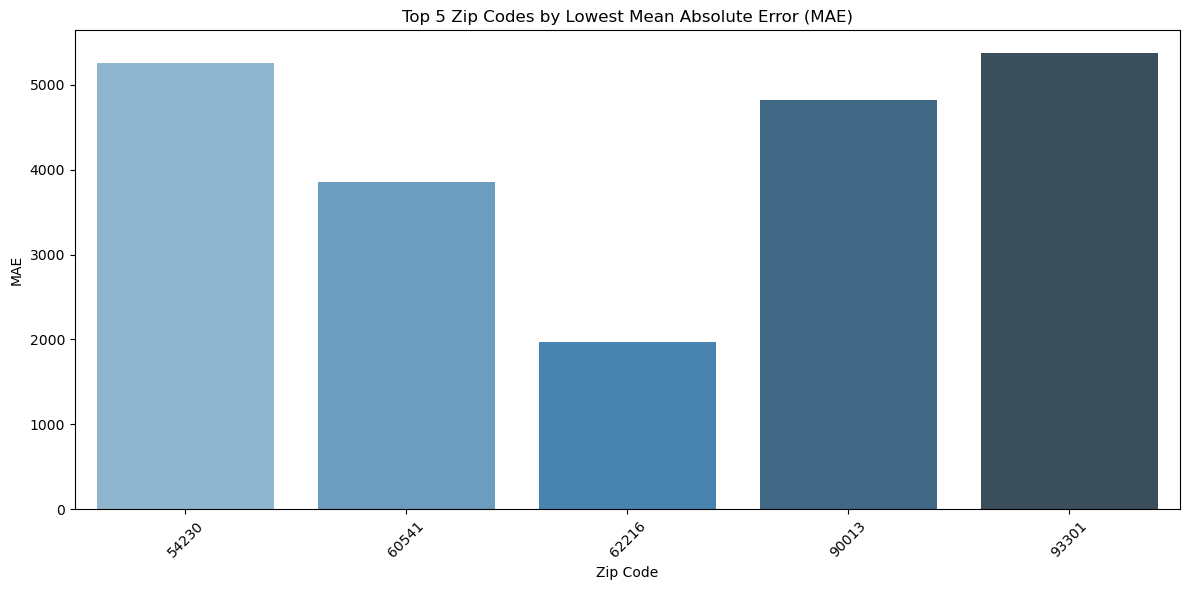

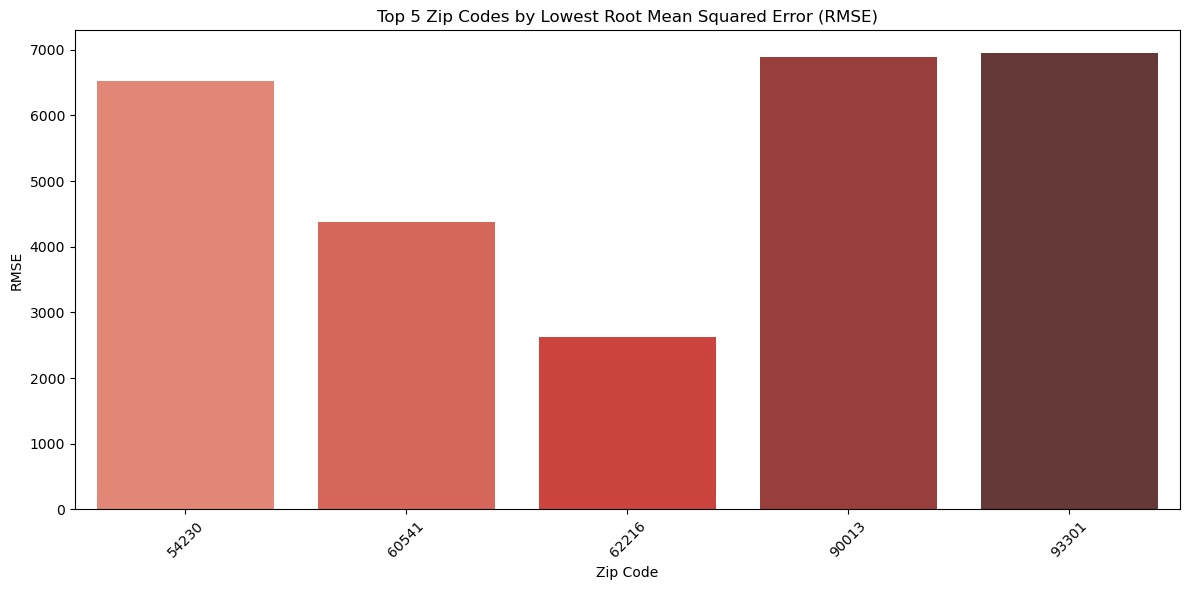

In [42]:


# Create a DataFrame for visualization
summary_df = pd.DataFrame(zip_code_results).T[['MAE', 'RMSE']]
summary_df['ZipCode'] = summary_df.index

# Identify the top 5 zip codes by lowest MAE and RMSE
top_5_mae_zipcodes = summary_df.sort_values(by='MAE').head(5)['ZipCode'].tolist()
top_5_rmse_zipcodes = summary_df.sort_values(by='RMSE').head(5)['ZipCode'].tolist()

# Filter the summary_df to only include the top 5 zip codes by MAE and RMSE
filtered_summary_mae = summary_df[summary_df['ZipCode'].isin(top_5_mae_zipcodes)]
filtered_summary_rmse = summary_df[summary_df['ZipCode'].isin(top_5_rmse_zipcodes)]

# Plot MAE for the top 5 zip codes based on lowest MAE
plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_summary_mae, x='ZipCode', y='MAE', palette='Blues_d')
plt.title('Top 5 Zip Codes by Lowest Mean Absolute Error (MAE)')
plt.xlabel('Zip Code')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot RMSE for the top 5 zip codes based on lowest RMSE
plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_summary_rmse, x='ZipCode', y='RMSE', palette='Reds_d')
plt.title('Top 5 Zip Codes by Lowest Root Mean Squared Error (RMSE)')
plt.xlabel('Zip Code')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
